In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('yelp_combined.csv')
df.head()

,address,avg_rating,business_hours,category,covid_services,covid_update_time,covid_updates_text,cuisine,location,num_reviews,phone_num,price_range,recent_reviews,restaurant_name,url
0,"1283 9th Ave, San Francisco, CA 94122",4.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': '11:...","Sushi Bars,Japanese",{'Takeout': True},"Posted on May 27, 2020","""We are currently open for TAKEOUT only on Wed...",japanese,"San Francisco, CA",1804,(415) 566-1770,$$,"[('5 star rating', '7/22/2020'), ('4 star rati...",Ebisu,https://www.yelp.com/biz/ebisu-san-francisco?o...
1,"2450 Clement St, San Francisco, CA 94121",4.0,"{'Mon': '4:00 pm - 8:30 pm', 'Tue': 'Closed', ...","Japanese,Sushi Bars","{'Delivery': True, 'Takeout': True}","Posted on April 26, 2020","""Sorry to keep you waiting. We finally finishe...",japanese,"San Francisco, CA",508,(415) 386-8008,$$,"[('5 star rating', '7/4/2020'), ('5 star ratin...",Daigo Sushi,https://www.yelp.com/biz/daigo-sushi-san-franc...
2,"310 Linden Ave, South San Francisco, CA 94080",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","Sushi Bars,Japanese","{'Delivery': True, 'Takeout': True}",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",710,(650) 873-1084,$$,"[('1 star rating', '7/16/2020'), ('5 star rati...",Amami San Sushi,https://www.yelp.com/biz/amami-san-sushi-south...
3,"307 Kearny St, Ste 204, San Francisco, CA 94108",4.0,"{'Mon': '11:00 am - 7:00 pm', 'Tue': '11:00 am...",Japanese Curry,"{'Outdoor seating': True, 'Delivery': True, 'T...",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",1722,(415) 773-1101,$$,"[('2 star rating', '7/16/2020'), ('5 star rati...",Muracci's Japanese Curry & Grill,https://www.yelp.com/biz/muraccis-japanese-cur...
4,"3409 Geary Blvd, San Francisco, CA 94118",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","Sushi Bars,Ramen,Izakaya","{'Delivery': True, 'Takeout': True}","Posted on June 7, 2020","""We are currently open for TAKE OUT,We offer L...",japanese,"San Francisco, CA",768,(415) 742-4309,$$,"[('5 star rating', '7/20/2020'), ('5 star rati...",Kaiju Eats Ramen and Izakaya,https://www.yelp.com/biz/kaiju-eats-ramen-and-...


In [4]:
df.shape

(4936, 15)

In [5]:
df.dtypes

address                object
avg_rating            float64
business_hours         object
category               object
covid_services         object
covid_update_time      object
covid_updates_text     object
cuisine                object
location               object
num_reviews             int64
phone_num              object
price_range            object
recent_reviews         object
restaurant_name        object
url                    object
dtype: object

## Handling Missing Data

In [6]:
np.sum(df.isnull())

address                 2
avg_rating             30
business_hours          0
category                2
covid_services          0
covid_update_time     135
covid_updates_text    160
cuisine                 0
location                0
num_reviews             0
phone_num             128
price_range           504
recent_reviews         70
restaurant_name         2
url                     0
dtype: int64

- Dropping rows with missing avg_rating, recent_reviews or category since the analysis centers around those variables

In [7]:
df.dropna(subset=['recent_reviews','avg_rating', 'category'], inplace=True)
df.shape

(4866, 15)

- Dropping rows wherenum_reviews <10 

In [8]:
df = df[df.num_reviews >= 10]
df.shape

(4742, 15)

## Variable Type Conversion

In [9]:
df.loc[[0]].dtypes

address                object
avg_rating            float64
business_hours         object
category               object
covid_services         object
covid_update_time      object
covid_updates_text     object
cuisine                object
location               object
num_reviews             int64
phone_num              object
price_range            object
recent_reviews         object
restaurant_name        object
url                    object
dtype: object

In [10]:
print(type(df.business_hours[0]))
print(type(df.covid_services[0]))
print(type(df.recent_reviews[0]))

<class 'str'>
<class 'str'>
<class 'str'>


- Convert recent_reviews, business_hours and covid_services from the string representation to dictionaries and list

In [11]:
import ast

df.recent_reviews = df.recent_reviews.apply(lambda x: ast.literal_eval(x))
df.business_hours = df.business_hours.apply(lambda x: ast.literal_eval(x))
df.covid_services = df.covid_services.apply(lambda x: ast.literal_eval(x))

In [12]:
df.category = df.category.map(lambda x: x.split(','))

In [13]:
# Convert price range to integer value 
df.price_range = df.price_range.apply(lambda x: len(x) if isinstance(x, float)==False else np.nan)


In [14]:
np.sum(df.price_range.isnull())

321

In [15]:
df.price_range.mean()

1.8893915403754806

## Derive New Column Variables

In [16]:
df.head(3)

,address,avg_rating,business_hours,category,covid_services,covid_update_time,covid_updates_text,cuisine,location,num_reviews,phone_num,price_range,recent_reviews,restaurant_name,url
0,"1283 9th Ave, San Francisco, CA 94122",4.0,"{'Mon': 'Closed', 'Tue': 'Closed', 'Wed': '11:...","[Sushi Bars, Japanese]",{'Takeout': True},"Posted on May 27, 2020","""We are currently open for TAKEOUT only on Wed...",japanese,"San Francisco, CA",1804,(415) 566-1770,2.0,"[(5 star rating, 7/22/2020), (4 star rating, 7...",Ebisu,https://www.yelp.com/biz/ebisu-san-francisco?o...
1,"2450 Clement St, San Francisco, CA 94121",4.0,"{'Mon': '4:00 pm - 8:30 pm', 'Tue': 'Closed', ...","[Japanese, Sushi Bars]","{'Delivery': True, 'Takeout': True}","Posted on April 26, 2020","""Sorry to keep you waiting. We finally finishe...",japanese,"San Francisco, CA",508,(415) 386-8008,2.0,"[(5 star rating, 7/4/2020), (5 star rating, 7/...",Daigo Sushi,https://www.yelp.com/biz/daigo-sushi-san-franc...
2,"310 Linden Ave, South San Francisco, CA 94080",4.0,"{'Mon': '11:30 am - 2:30 pm', 'Tue': '11:30 am...","[Sushi Bars, Japanese]","{'Delivery': True, 'Takeout': True}",Powered by HDScores,Elite '2020,japanese,"San Francisco, CA",710,(650) 873-1084,2.0,"[(1 star rating, 7/16/2020), (5 star rating, 7...",Amami San Sushi,https://www.yelp.com/biz/amami-san-sushi-south...


- New column variables: count of recent ratings (after 3/1/2020) and avg_recent_rating

In [17]:
def split_recent_reviews(rr, date_cut = pd.to_datetime('3/1/2020')):
    try:
        ratings, dates = zip(*rr)
    except Exception as e:
        print(f"Trouble with {rr} here is: {e}")
        return pd.Series(dict(mean_rating = np.nan, n_ratings = np.nan))
    dates = pd.to_datetime(dates)
    keep_idxs = dates >= date_cut
    ratings = pd.Series(ratings)[keep_idxs].apply(lambda x: int(x[0]))
    dates = dates[keep_idxs]
    mean_rating = ratings.mean()
    n_ratings = ratings.shape[0]
    return pd.Series(dict(mean_rating = mean_rating, n_ratings = n_ratings))

In [18]:
df[['recent_rating','num_recent_rating']] = df.recent_reviews.apply(split_recent_reviews)[['mean_rating','n_ratings']]

- Filtering out rows where number of recent rating = 0

In [19]:
df = df[df.num_recent_rating > 0]
df.shape


(4484, 17)

- Create Covid service related columns: delivery, takeout, outdoor_seating, sit-down_dining, curbside_pickup, safety_measure as boolean variable 

In [20]:
df['delivery'] = df.covid_services.map(lambda x: "Delivery" in x.keys() and x['Delivery']==True)
df['takeout'] = df.covid_services.map(lambda x: "Takeout" in x.keys() and x['Takeout'] ==True)
df['outdoor_seating'] = df.covid_services.map(lambda x: "Outdoor seating" in x.keys() and x['Outdoor seating'] ==True)
df['sit-down_dining'] = df.covid_services.map(lambda x: "Sit-down dining" in x.keys() and x['Sit-down dining'] ==True)
df['curbside_pickup'] = df.covid_services.map(lambda x: "Curbside pickup" in x.keys() and x['Curbside pickup'] ==True)
df['safety_measure'] = df.covid_services.map(lambda x: set(x.keys()) & \
    set(['Contactless payments', 'Masks required', 'Staff wears gloves', 'Staff wears masks', \
         'Limited capacity', 'Hand sanitizer provided', 'Social distancing enforced', 'Temperature checks']) != set())


In [21]:
# Filtering out rows where number of recent rating = 0
df = df[df.num_recent_rating > 0]
df.shape

(4484, 23)

- Create new variable: number of safety measures available

In [91]:
df['num_safety_measure'] = df.covid_services.map(lambda x: len(set(x.keys()) & \
    set(['Contactless payments', 'Masks required', 'Staff wears gloves', 'Staff wears masks', \
         'Limited capacity', 'Hand sanitizer provided', 'Social distancing enforced',
         'Temperature checks'])))

- Create new variable delta_rating

In [22]:
df['delta_rating'] = df['recent_rating'] - df['avg_rating']

In [23]:
df[['avg_rating','recent_rating','delta_rating']].head(10)

,avg_rating,recent_rating,delta_rating
0,4.0,4.157895,0.157895
1,4.0,4.666667,0.666667
2,4.0,3.052632,-0.947368
3,4.0,3.800000,-0.200000
4,4.0,4.368421,0.368421
5,4.0,3.500000,-0.500000
6,4.0,4.666667,0.666667
7,4.5,4.437500,-0.062500
8,4.5,4.900000,0.400000
9,4.5,4.142857,-0.357143


In [24]:
df.delta_rating.describe()

count    4484.000000
mean        0.086924
std         0.709613
min        -3.500000
25%        -0.263158
50%         0.142857
75%         0.500000
max         2.500000
Name: delta_rating, dtype: float64

- Create new variable: weekly total business hours

In [25]:
import re
import datetime
hour1 = df.business_hours.head()[0]
def getHoursOpenPerWeek(hours):
    totalHours = 0
    for hoursOfDay in hours.values():
#         print(hours)
#         print(hoursOfDay)
        if (hoursOfDay == None):
            continue
        reResult = re.match("(\d+:\d+\s[apm]{2})\s\-\s(\d+:\d+\s[apm]{2})", hoursOfDay)
#         print(reResult)
        if (reResult == None):
            continue
        starting = datetime.datetime.strptime(reResult.group(1), '%I:%M %p')
        closing = datetime.datetime.strptime(reResult.group(2), '%I:%M %p')
        difference = closing - starting
        differenceInHours = difference.seconds/3600
        totalHours += differenceInHours
    return totalHours
    
def getHoursOpenPerWeek2(hours):
    print(hours)
    
getHoursOpenPerWeek(hour1)
# d1 = datetime.datetime.strptime('11:00 AM', '%I:%M %p')
# d2 = datetime.datetime.strptime('1:31 PM', '%I:%M %p')
# print(d1)
# print(d2)
# print((d2-d1).seconds/3600)

28.0

In [26]:
df['weekly_total_hours'] = df.business_hours.apply(lambda x: getHoursOpenPerWeek(x))

In [27]:
df.weekly_total_hours.describe()

count    4484.000000
mean       57.299602
std        25.801185
min         0.000000
25%        35.000000
50%        62.250000
75%        76.500000
max       147.000000
Name: weekly_total_hours, dtype: float64

## Exploratory Data Analysis 

In [28]:
df.mean()

avg_rating              3.991302
num_reviews           523.547948
price_range             1.899427
recent_rating           4.078226
num_recent_rating       8.619090
delivery                0.760259
takeout                 0.834969
outdoor_seating         0.097235
sit-down_dining         0.106155
curbside_pickup         0.206066
safety_measure          0.150758
delta_rating            0.086924
weekly_total_hours     57.299602
dtype: float64

In [29]:
np.sum(df.num_recent_rating)

38648.0

In [30]:
np.sum(df.num_reviews)

2347589

### - General Overview 

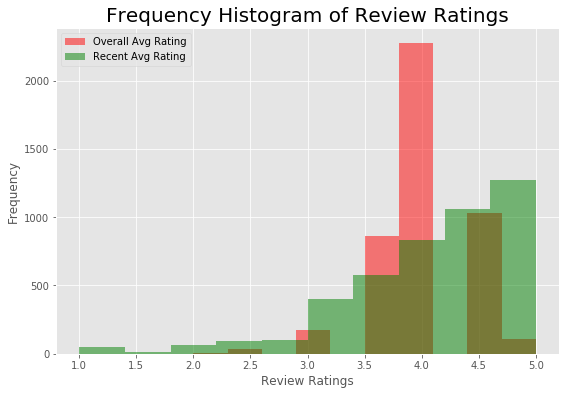

In [31]:
plt.figure(figsize=(9,6))
plt.hist(df.avg_rating, color = 'r', label = 'Overall Avg Rating', alpha=0.5)
plt.hist(df.recent_rating, color = 'g', label = 'Recent Avg Rating', alpha = 0.5)
plt.title('Frequency Histogram of Review Ratings', fontsize = 20)
plt.ylabel('Frequency')
plt.xlabel('Review Ratings')
plt.legend()

In [61]:
print(np.mean(df.avg_rating))
print(np.mean(df.recent_rating))
print(np.mean(df.delta_rating))

3.9913024085637825
4.078226426285017
0.0869240177212256


In [ ]:
# insight: overall people give 4 start reviews the most, recently the review ratings are skewed to the left,
# aggregating more to higher reviews, with a overall increase of 0.09

Text(0, 0.5, 'Frequency')

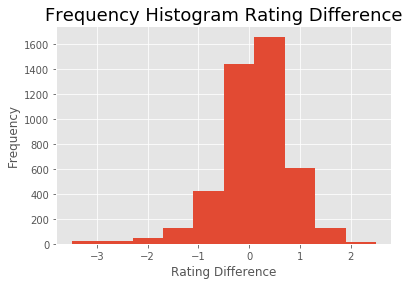

In [32]:
plt.hist(df.delta_rating)
plt.title('Frequency Histogram Rating Difference', fontsize = 18)
plt.xlabel('Rating Difference')
plt.ylabel('Frequency')

In [33]:
df.columns

Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'recent_rating', 'num_recent_rating',
       'delivery', 'takeout', 'outdoor_seating', 'sit-down_dining',
       'curbside_pickup', 'safety_measure', 'delta_rating',
       'weekly_total_hours'],
      dtype='object')

In [63]:
np.mean(df.num_recent_rating)

8.619090098126673

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe01c686bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe01c686f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe01f8f3990>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe01f5ca3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe02063e310>],
 'means': []}

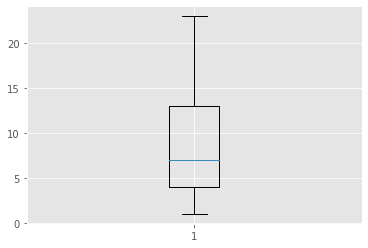

In [34]:
plt.boxplot(df.num_recent_rating)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Frequency')

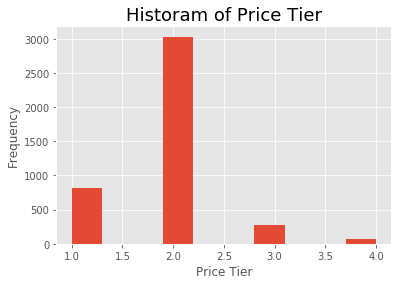

In [35]:
plt.hist(df.price_range)
plt.title('Historam of Price Tier', fontsize = 18)
plt.xlabel('Price Tier')
plt.ylabel('Frequency')

In [36]:
df.mean()

avg_rating              3.991302
num_reviews           523.547948
price_range             1.899427
recent_rating           4.078226
num_recent_rating       8.619090
delivery                0.760259
takeout                 0.834969
outdoor_seating         0.097235
sit-down_dining         0.106155
curbside_pickup         0.206066
safety_measure          0.150758
delta_rating            0.086924
weekly_total_hours     57.299602
dtype: float64

Text(0.5, 1.0, 'Percentage of Service Availability')

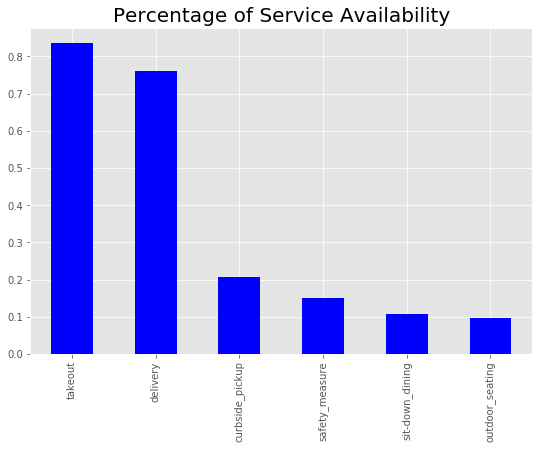

In [66]:
import matplotlib.ticker as mtick
plt.figure(figsize=(9,6))
ax = df[['delivery','takeout','outdoor_seating','sit-down_dining', 
    'curbside_pickup', 'safety_measure']].mean().sort_values(ascending=False).plot.bar(color='b')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of Service Availability', fontsize = 20)

In [ ]:
# insights: 83% takeout, 76% delivery, 10% outdoor seating, 10% sit-down dining, 20% curbside pickup

Text(0, 0.5, 'Frequency')

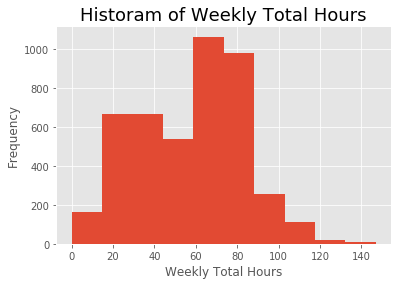

In [39]:
plt.hist(df.weekly_total_hours)
plt.title('Historam of Weekly Total Hours', fontsize = 18)
plt.xlabel('Weekly Total Hours')
plt.ylabel('Frequency')

In [64]:
np.mean(df.weekly_total_hours)

57.299602289622364

In [ ]:
# insights: Average weekly open hours of all restaurants are 57 hours, about 8 hours a day

In [41]:
df.columns

Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'recent_rating', 'num_recent_rating',
       'delivery', 'takeout', 'outdoor_seating', 'sit-down_dining',
       'curbside_pickup', 'safety_measure', 'delta_rating',
       'weekly_total_hours'],
      dtype='object')

Text(0.5, 1.0, 'Recent Rating by Price Range')

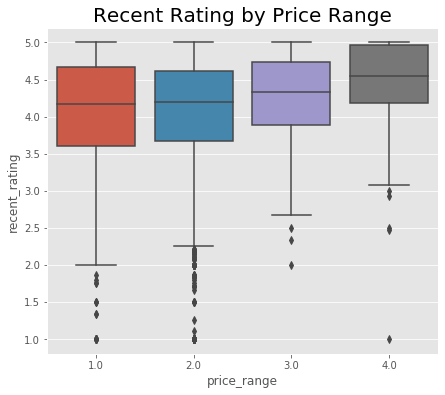

In [42]:
import seaborn as sns
plt.figure(figsize=(7,6))
sns.boxplot(x='price_range',y='recent_rating', data=df).set_title('Recent Rating by Price Range', fontsize=20)

In [ ]:
# insights: while all recent ratings are quite similar, it seems like restaurants with higher price tend to get
# better review ratings during the recent covid period

In [68]:
price_group = df.groupby('price_range')

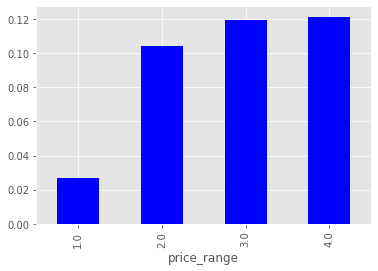

In [71]:
price_group.mean()['outdoor_seating'].plot.bar(color = 'b')

In [ ]:
# insights: outdoor seating is strongly desired 

In [72]:
price_group.mean()

,avg_rating,num_reviews,recent_rating,num_recent_rating,delivery,takeout,outdoor_seating,sit-down_dining,curbside_pickup,safety_measure,delta_rating,weekly_total_hours
price_range,,,,,,,,,,,,
1.0,3.933618,350.064555,4.025078,6.846529,0.690621,0.805116,0.026797,0.035323,0.137637,0.063337,0.091460,66.455704
2.0,3.961069,578.237215,4.051907,9.084131,0.792148,0.856153,0.103926,0.122402,0.219070,0.167931,0.090839,57.397405
3.0,4.069030,903.194030,4.231982,8.208955,0.660448,0.735075,0.119403,0.138060,0.253731,0.182836,0.162953,40.652052
4.0,4.310606,740.409091,4.373377,8.166667,0.439394,0.621212,0.121212,0.090909,0.181818,0.166667,0.062771,25.859848


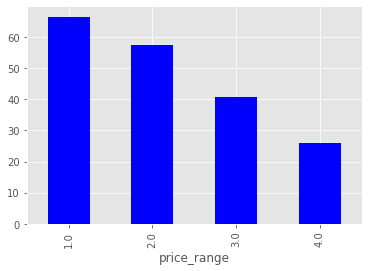

In [75]:
price_group.mean()['weekly_total_hours'].plot.bar(color = 'b')

In [ ]:
# insights: the more exepnsive restaurants tend to operate shorter hours 

In [43]:
# Scatter plot of weekly total hours vs. delta rating 

Text(0, 0.5, 'Delta Rating')

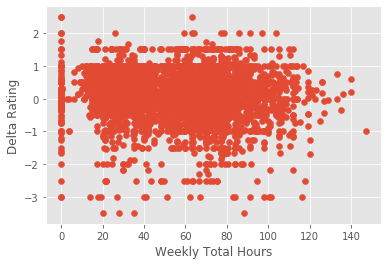

In [44]:
plt.scatter(df['weekly_total_hours'], df['delta_rating'])
plt.xlabel('Weekly Total Hours')
plt.ylabel('Delta Rating')

# Looks like no correlation

Text(0, 0.5, 'Recent Rating')

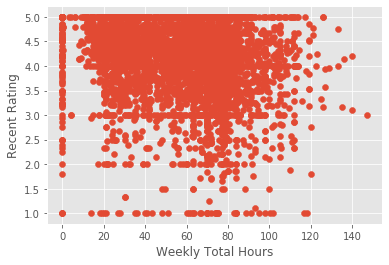

In [45]:
plt.scatter(df['weekly_total_hours'], df['recent_rating'])
plt.xlabel('Weekly Total Hours')
plt.ylabel('Recent Rating')

In [ ]:
# insights: no correlation between weekly total hours and recent rating or rating improvement

Text(0.5, 1.0, 'Recent Rating by Outdoor Seating YN')

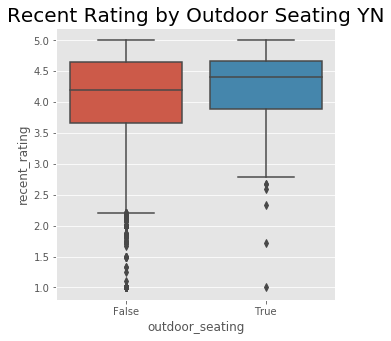

In [78]:
plt.figure(figsize=(5,5))
sns.boxplot(x='outdoor_seating',y='recent_rating', data=df).set_title('Recent Rating by Outdoor Seating YN', fontsize=20)

Text(0.5, 1.0, 'Recent Rating by Safety Measure YN')

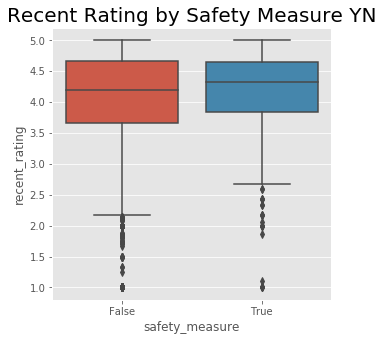

In [80]:
plt.figure(figsize=(5,5))
sns.boxplot(x='safety_measure',y='recent_rating', data=df).set_title('Recent Rating by Safety Measure YN', fontsize=20)

In [100]:
df.columns

Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'recent_rating', 'num_recent_rating',
       'delivery', 'takeout', 'outdoor_seating', 'sit-down_dining',
       'curbside_pickup', 'safety_measure', 'delta_rating',
       'weekly_total_hours', 'num_safety_measure'],
      dtype='object')

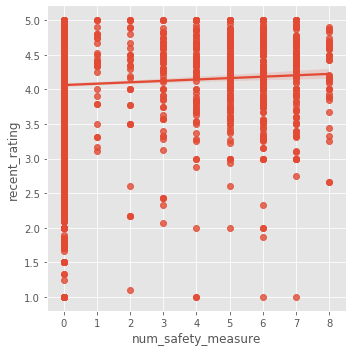

In [105]:
sns.lmplot("num_safety_measure", "recent_rating", df)

In [ ]:
# Insight: Safety measures are definitely good to have, and the more measures are impelmented, the better
# - list of all 8 safety measures: 'Contactless payments', 'Masks required', 'Staff wears gloves', 'Staff wears masks', 
# 'Limited capacity', 'Hand sanitizer provided', 'Social distancing enforced', 'Temperature checks'

Text(0.5, 1.0, 'Recent Rating by Takeout YN')

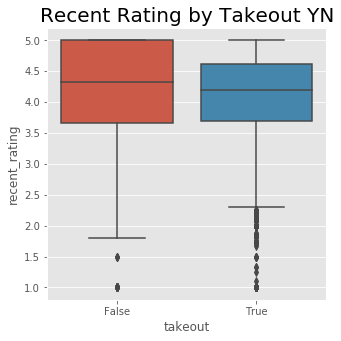

In [82]:
plt.figure(figsize=(5,5))
sns.boxplot(x='takeout',y='recent_rating', data=df).set_title('Recent Rating by Takeout YN', fontsize=20)

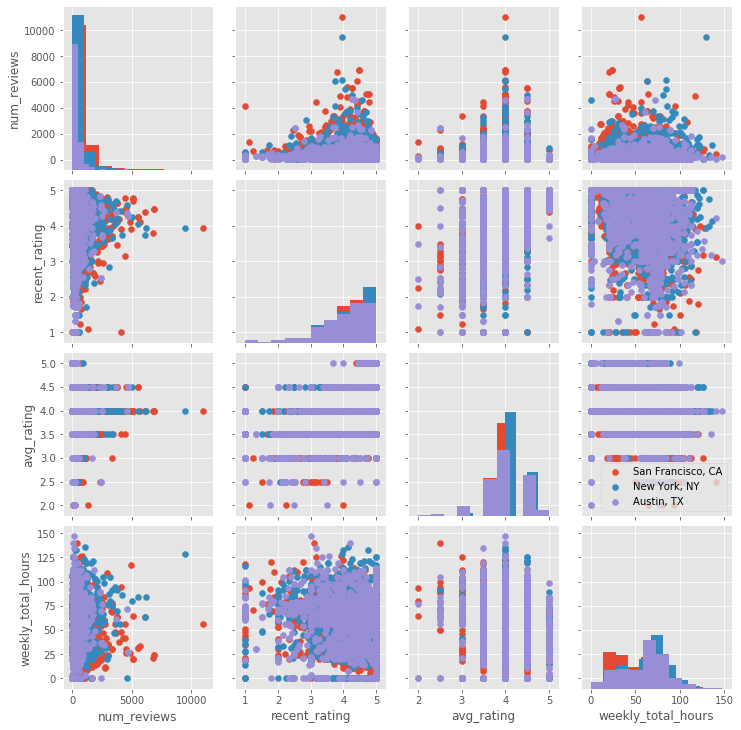

In [111]:
import seaborn as sns
g = sns.PairGrid(df[['num_reviews','recent_rating','avg_rating', 'weekly_total_hours', 'location']],
                hue = 'location')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.legend()

# g.map(plt.hist,alpha=0.5)

In [84]:
df.columns

Index(['address', 'avg_rating', 'business_hours', 'category', 'covid_services',
       'covid_update_time', 'covid_updates_text', 'cuisine', 'location',
       'num_reviews', 'phone_num', 'price_range', 'recent_reviews',
       'restaurant_name', 'url', 'recent_rating', 'num_recent_rating',
       'delivery', 'takeout', 'outdoor_seating', 'sit-down_dining',
       'curbside_pickup', 'safety_measure', 'delta_rating',
       'weekly_total_hours'],
      dtype='object')

In [50]:
df.location.unique()

array(['San Francisco, CA', 'New York, NY', 'Austin, TX'], dtype=object)

### - By Cuisine Type 

In [51]:
cuisine_group = df.groupby('cuisine')

In [52]:
cuisine_group.agg('mean')

,avg_rating,num_reviews,price_range,recent_rating,num_recent_rating,delivery,takeout,outdoor_seating,sit-down_dining,curbside_pickup,safety_measure,delta_rating,weekly_total_hours
cuisine,,,,,,,,,,,,,
american,4.019231,792.199704,2.035826,4.085791,9.906805,0.748521,0.840237,0.139053,0.189349,0.300296,0.210059,0.066560,60.127268
chinese,3.821759,398.317901,1.651961,3.972801,7.785494,0.736111,0.820988,0.055556,0.054012,0.131173,0.098765,0.151042,58.106096
italian,4.061481,622.124444,2.087774,4.177814,8.905185,0.717037,0.791111,0.108148,0.131852,0.280000,0.161481,0.116333,54.051111
japanese,4.042105,479.169925,2.152488,4.118314,8.276692,0.733835,0.815038,0.102256,0.099248,0.196992,0.181955,0.076209,45.598120
mediterranean,4.114931,405.361493,1.866521,4.140288,7.972495,0.823183,0.848723,0.088409,0.076621,0.186640,0.137525,0.025357,61.218828
mexican,3.941628,449.029186,1.625418,4.006693,7.840246,0.737327,0.841782,0.089094,0.090630,0.168971,0.102919,0.065065,69.773425
thai,3.959848,479.883333,1.842532,4.054441,9.437879,0.840909,0.890909,0.093939,0.090909,0.168182,0.156061,0.094592,53.397727


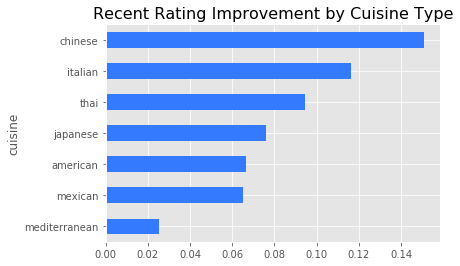

In [53]:
cuisine_group.mean()['delta_rating'].sort_values(ascending=True).plot.barh(color = '#337AFF')
plt.title('Recent Rating Improvement by Cuisine Type', fontsize = 16)
plt.xlabel=('Avg Recent Rating - Avg Overall Rating')

In [ ]:
# insight: describe recent rating improvement by cuisine type 

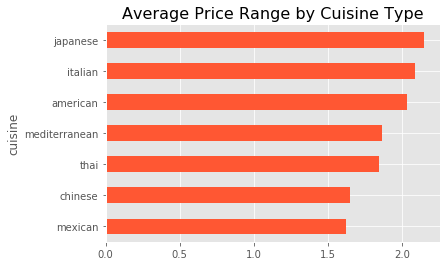

In [54]:
cuisine_group.mean()['price_range'].sort_values(ascending=True).plot.barh(color = '#FF5733')
plt.title('Average Price Range by Cuisine Type', fontsize = 16)
plt.xlabel=('Average Price Range')

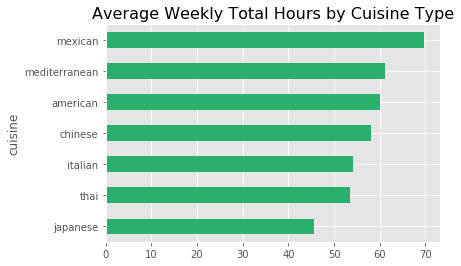

In [55]:
cuisine_group.mean()['weekly_total_hours'].sort_values(ascending=True).plot.barh(color = '#2AB06D')
plt.title('Average Weekly Total Hours by Cuisine Type', fontsize = 16)
plt.xlabel=('Average Weekly Total Hours')

Text(0, 0.5, 'Review Rating')

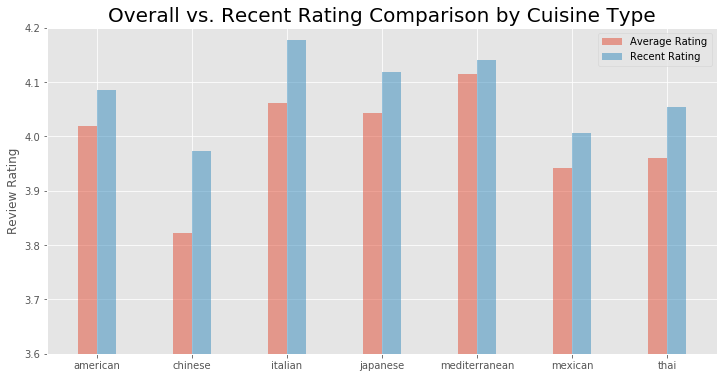

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
pos = np.arange(7)
width = 0.2
b1 = ax.bar(pos, cuisine_group.mean()['avg_rating'],
            width=width, label = 'Average Rating', alpha = 0.5)
b2 = ax.bar(pos+width, cuisine_group.mean()['recent_rating'],
            width=width, label = 'Recent Rating', alpha = 0.5)
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(cuisine_group.mean().index)
plt.ylim((3.6,4.2))
plt.legend()
plt.title('Overall vs. Recent Rating Comparison by Cuisine Type', fontsize = 20)
plt.ylabel('Review Rating')

In [57]:
#  df[['delivery','takeout','outdoor_seating','sit-down_dining', 
#     'curbside_pickup', 'safety_measure']].mean()
    
temp = cuisine_group.agg('mean')[['delivery','takeout','outdoor_seating',
                           'sit-down_dining', 'curbside_pickup', 'safety_measure']]
temp = temp.swapaxes("index","columns")

TypeError: 'str' object is not callable

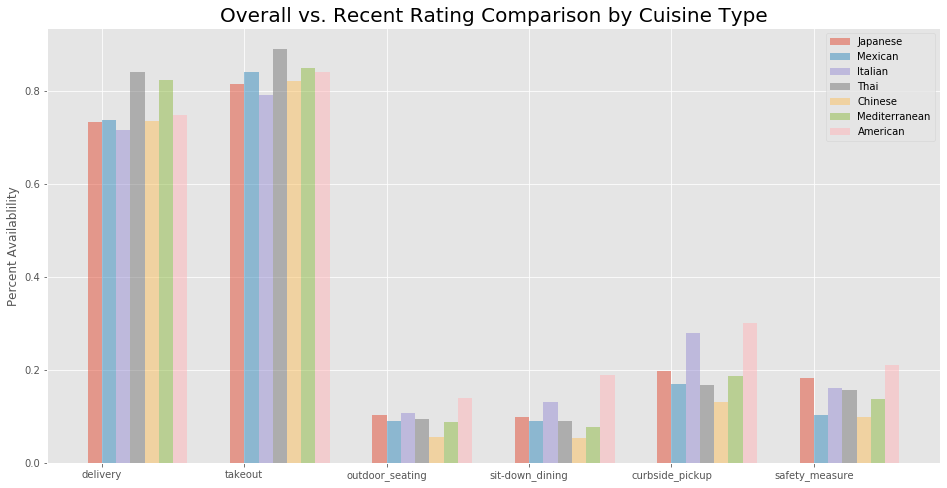

In [58]:
fig, ax = plt.subplots(figsize=(16, 8))
x = np.arange(6)
width = 0.1
b1 = ax.bar(x, temp.japanese,
            width=width, label = 'Japanese', alpha = 0.5)
b2 = ax.bar([p+width for p in x], temp.mexican,
            width=width, label = 'Mexican', alpha = 0.5)
b3 = ax.bar([p+width*2 for p in x], temp.italian,
            width=width, label = 'Italian', alpha = 0.5)
b4 = ax.bar([p+width*3 for p in x], temp.thai,
            width=width, label = 'Thai', alpha = 0.5)
b5 = ax.bar([p+width*4 for p in x], temp.chinese,
            width=width, label = 'Chinese', alpha = 0.5)
b6 = ax.bar([p+width*5 for p in x], temp.mediterranean,
            width=width, label = 'Mediterranean', alpha = 0.5)
b7 = ax.bar([p+width*6 for p in x], temp.american,
            width=width, label = 'American', alpha = 0.5)

ax.set_xticks(x + width / 2)
ax.set_xticklabels(temp.index)
plt.legend()
plt.title('Overall vs. Recent Rating Comparison by Cuisine Type', fontsize = 20)
plt.ylabel('Percent Availablility')
plt.xlabel('Restaurant Services')

#### From graph above: 
- Thai restaurants offer the most delivery and takeout, secondly Mediterranean 
- American restaurants offer the most outdoor seating, sit-down dining, curbside pickup services, and are the best at implementing safety measures 

Text(0.5, 1.0, 'Rating Comparison by Cuisine Type, Delivery Y/N')

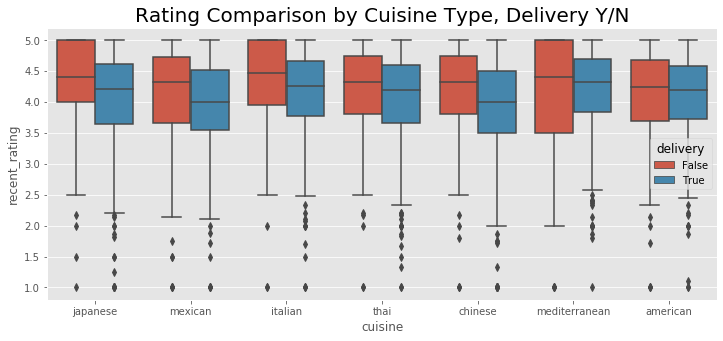

In [106]:
plt.figure(figsize=(12,5))
sns.boxplot(x='cuisine',y='recent_rating', hue='delivery', data=df)
plt.title('Rating Comparison by Cuisine Type, Delivery Y/N', fontsize = 20)

Text(0.5, 1.0, 'Rating Comparison by Cuisine Type, Outdoor Seating Y/N')

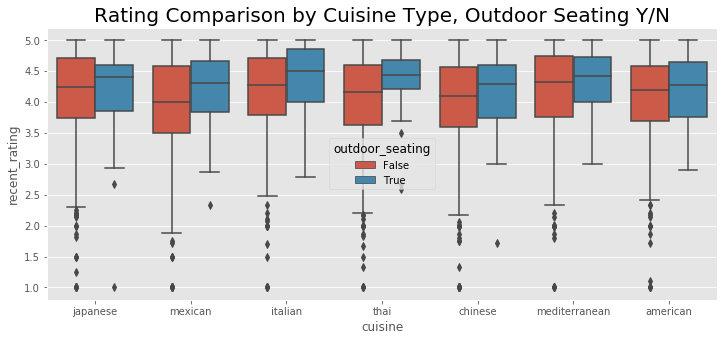

In [107]:
plt.figure(figsize=(12,5))
sns.boxplot(x='cuisine',y='recent_rating', hue='outdoor_seating', data=df)
plt.title('Rating Comparison by Cuisine Type, Outdoor Seating Y/N', fontsize = 20)

Text(0.5, 1.0, 'Rating Comparison by Cuisine Type, Safety Measures Y/N')

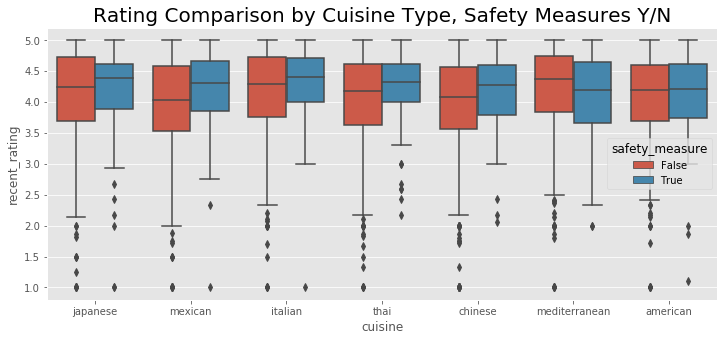

In [108]:
plt.figure(figsize=(12,5))
sns.boxplot(x='cuisine',y='recent_rating', hue='safety_measure', data=df)
plt.title('Rating Comparison by Cuisine Type, Safety Measures Y/N', fontsize = 20)

### By location

In [ ]:
loc_group = df.groupby('location')

In [ ]:
loc_group.mean()

In [ ]:
import seaborn as sns

sns.boxplot(x='location',y='recent_rating', hue='outdoor_seating', data=df)

In [ ]:
sns.boxplot(x='location',y='recent_rating', hue='outdoor_seating', data=df)

In [ ]:
sns.boxplot(x='location',y='recent_rating', hue='curbside_pickup', data=df)

In [ ]:
x = df[['location','delta_rating']]
x.boxplot(by='location', column = 'delta_rating')
plt.ylabel('delta_rating')

In [ ]:
x = df[['location','price_range']]
x.boxplot(by='location', column = 'price_range')
plt.ylabel('price')

In [ ]:
x = df[['cuisine','price_range']]
x.boxplot(by='cuisine', column = 'price_range')
plt.ylabel('price')

#### Two sample t-test for delivery, takeout, safety_measure and outdoor_seating

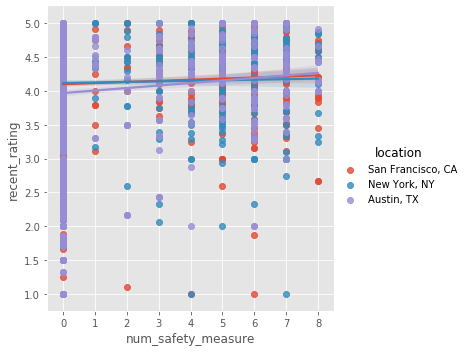

In [104]:
sns.lmplot("num_safety_measure", "recent_rating",df, hue = 'location')